In [1]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clt

In [9]:
elev = np.array(Image.open("data/2d/elev.tif"))
slope = np.array(Image.open("data/2d/slope.tif"))
aspect = np.array(Image.open("data/2d/aspect.tif"))

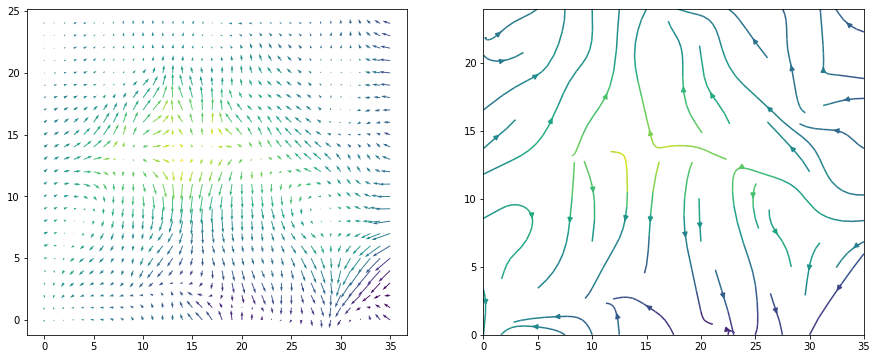

In [10]:
rads = np.radians(aspect+90)
u,v = slope*(np.sin(rads),np.cos(rads))
x = np.arange(slope.shape[1])
y = np.arange(slope.shape[0])
X,Y = np.meshgrid(x,y)
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,6))

ax1.quiver(X, Y, u, v, elev)
ax2.streamplot(X, Y, u,v,color=elev,density=0.5)

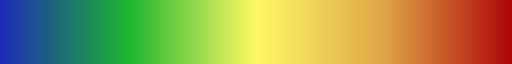

In [12]:
colors = ["#ae0707","#dfa647","#fff965","#1db630","#1d2cb6"]
segmented = clt.LinearSegmentedColormap.from_list('segmented',colors) # obie metody mają niekompatybilną składnię
segmented.reversed()


In [13]:
class customNorm(clt.Normalize):
    def __init__(self,stops,vmin=-np.inf,vmax=np.inf,clip=False):
        super().__init__(vmin, vmax, clip)
        self.stops = np.asarray(stops)
        self.mapable = np.linspace(0,1,len(self.stops))
        self.vmin=vmin
        self.vmax=vmax

    def __call__(self,value,clip=None):
        return np.ma.masked_array(np.interp(value,self.stops,self.mapable,
                         left=self.vmin, right=self.vmax))

    def inverse(self,value):
        return np.interp(value,self.mapable,self.stops,
                         left=self.vmin, right=self.vmax)

In [46]:
breaks = [60,82,90,95,100,110,120,125,145]
b_norm = clt.BoundaryNorm(breaks,ncolors=256)
c_norm = customNorm(breaks)
quants = np.quantile(elev.flatten(),q=np.linspace(0,1,9)) 
q_norm = customNorm(quants)

grd = np.meshgrid(np.arange(elev.shape[1]),np.arange(elev.shape[0]))

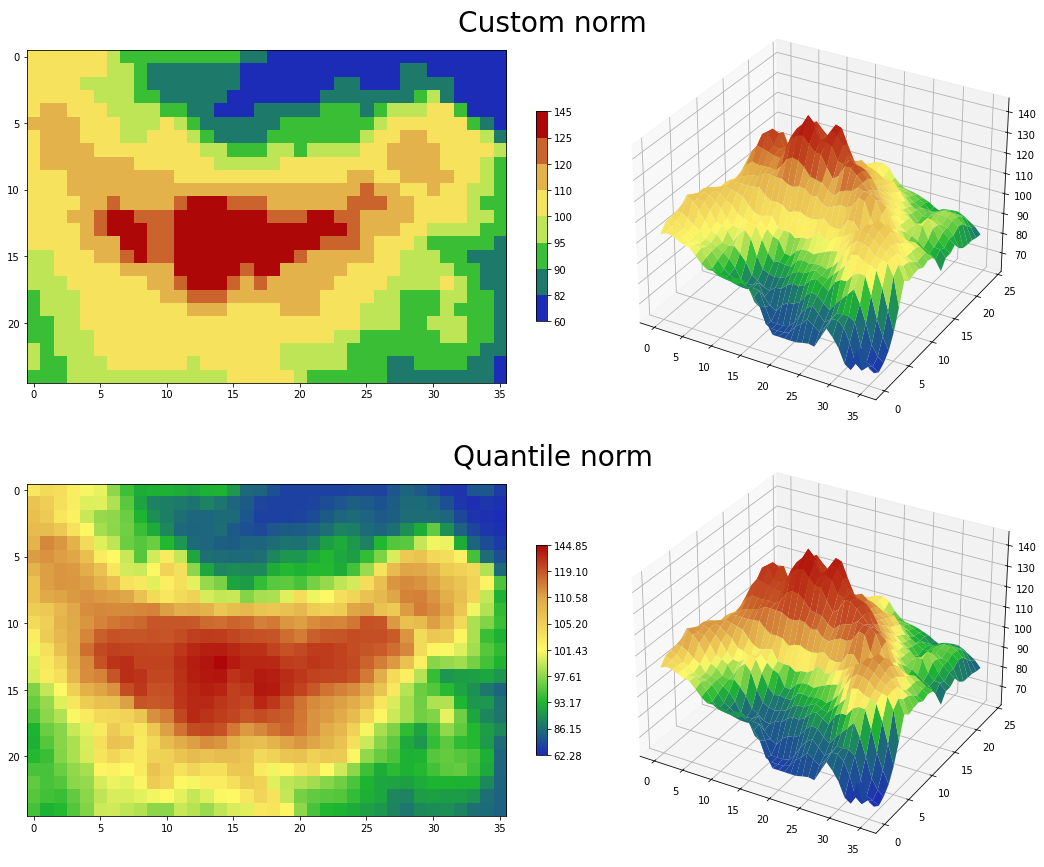

In [60]:

fig = plt.figure(figsize=(16,12))
subfig1,subfig2 = fig.subfigures(2, 1, hspace=0.007)
gs1 = subfig1.add_gridspec(1,2)
ax1 = subfig1.add_subplot(gs1[0])
ax2 = subfig1.add_subplot(gs1[1],projection='3d')
b1 = ax1.imshow(elev,cmap=segmented.reversed(),norm=b_norm)
b2 = ax2.plot_surface(grd[0],grd[1],elev,cmap=segmented.reversed(),norm=c_norm)
subfig1.colorbar(b1,ax=ax1,shrink=0.5,ticks=breaks,pad=0.05)
subfig1.suptitle('Custom norm', fontsize=28)

#
gs2 = subfig2.add_gridspec(1,2)
ax3 = subfig2.add_subplot(gs2[0])
ax4 = subfig2.add_subplot(gs2[1],projection='3d')
q1 = ax3.imshow(elev,cmap=segmented.reversed(),norm=q_norm)
q2 = ax4.plot_surface(grd[0],grd[1],elev,cmap=segmented.reversed(),norm=q_norm)
subfig2.colorbar(q1,ax=ax3,shrink=0.5,ticks=quants,pad=0.05)
subfig2.suptitle('Quantile norm', fontsize=28)
fig.tight_layout()


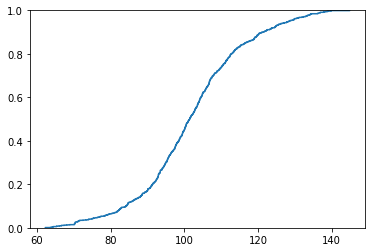

In [8]:
plt.ecdf(elev.flatten())

In [22]:
def histogramEq(y,nbins=256):
    histogram = np.histogram(y,nbins)[0]
    cdf = np.cumsum(histogram)
    eq = ((cdf-cdf.min())/(cdf.max()-cdf.min()))*(nbins-1)
    hst = np.linspace(y.min(),y.max(),nbins)
    f = np.interp(np.arange(nbins),eq,hst)
    return f

def normalize(v): # clt.Normalize(vmin,vmax)(values)
    v = np.asarray(v)
    return (v-v.min())/(v.max()-v.min())